# Capstone Project: The Battle of the Neighborhoods

## Segmenting and Clustering Neighborhoods in San Francisco

Applied Data Science Capstone by IBM/Coursera

<br>

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

<br>

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to make a recommandation for candidates who relocate to San Francisco and want to find an optimal place to live.

Specifically, this project aims to find **safe** neighborhoods in San Francisco, **close to the tech companies** and explore them to find the **most common venues** in each neighborhood, so that each area can be clearly expressed and best possible final location can be chosen by stakeholders.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. 

<br>

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:
* number crimes in the neighborhood
* distance between the neighborhood and the center of all tech companies
* venues in the neighborhood

Following data sources will be needed to extract/generate the required information:
- Geographic Locations and Boundaries of Neighborhoods in San Francisco: [sfgov](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h)
- Crime Incident Report (2018 - present): [sfgov](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783)
- All Bay Area Tech Companies List: [Github open source](https://github.com/connor11528/tech-companies-bay-area/blob/master/Bay-Area-Companies-List.csv)
- Venues returned for each neighborhood: [Foursquare API](https://developer.foursquare.com/docs/places-api/)

## Methodology <a name="methodology"></a>

**First Step**

We will collected the required data: geographic locations and boundaries of neighborhoods in San Francisco and locations of tech companies in San Francisco, to accurately calculate distances from the centroid of neighborhood to the centroid of all tech companies, we need to create our grid of locations in **Cartesian 2D coordinate system** which allows us to calculate distances in meters (not in latitude/longitude degrees). Then we’ll project those coordinates back to latitude/longitude degrees to be shown on Folium map. So we need to create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in meters). 

We have also collected the crime incident data, keep all data in 2020 and group them by neighborhood to calculate the total number of crimes in each neighborhood. Merge with neighborhoods dataframe and calculate the distance from each neighborhood to the centroid of all tech companies.

**Second Step**

We will use **k-means clustering** for neighborhood segmentation to find the candidate neighborhoods. We start by normalizing the dataset. Normalization is a statistical method that helps mathematical-based algorithms interpret features with different magnitudes and distributions equally. We use StandardScaler() to normalize our dataset. Then we run k-means to cluster the neighborhoods into 3 clusters. Note that each row in our dataset represents a neighborhood, and therefore, each row is assigned a label. Then we can easily check the centroid values by averaging the features in each cluster. Now, we can look at the distribution of neighborhoods based on their number of crimes and distance to the tech companies. Therefore we will keep neighborhoods in cluster 1 (green). Now we have our candidate neighborhoods ready.

We can create a **Choropleth map** , with lighter areas indicate high levels of safety, maker and circle show where the company gathers. (we need a GeoJSON file that defines the areas/boundaries of San Francisco. We can find the GeoJSON file from [sfgov](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h).) 

We can also create a map of San Francisco with candidate neighborhoods superimposed on top.

**Third Step**

We will focus on neighborhoods generated in step 2, use the **Foursquare API** to explore those neighborhoods and to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters using **k-means clustering**. We will use the **Folium library** to visualize the neighborhoods in San Francisco and their emerging clusters.

<br>

### Import Modules and Libraries:

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from itertools import chain

import folium

from sklearn.cluster import KMeans

import requests

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

<br>

### Download and Explore Dataset

#### 1. Geographic Locations and Boundaries of Neighborhoods

In [2]:
df_nei = pd.read_csv("SF_Neighborhoods .csv")

print(('The dataframe has {} neighborhoods.').format( df_nei.shape[0]))
df_nei.head()

The dataframe has 41 neighborhoods.


,the_geom,NHOOD
0,MULTIPOLYGON (((-122.38157774241415 37.7530704...,Bayview Hunters Point
1,MULTIPOLYGON (((-122.40361299982803 37.7493370...,Bernal Heights
2,MULTIPOLYGON (((-122.42655500055683 37.7694849...,Castro/Upper Market
3,MULTIPOLYGON (((-122.4062259995664 37.79755900...,Chinatown
4,MULTIPOLYGON (((-122.42398200023331 37.7315519...,Excelsior


In [3]:
# drop the unnecessary texts and parentheses
df_nei['the_geom'] =  df_nei['the_geom'].map(lambda x: x.lstrip('MULTIPOLYGON ()').rstrip('()'))
df_nei['the_geom'] = df_nei['the_geom'].str.replace('\)\)', '')
df_nei['the_geom'] = df_nei['the_geom'].str.replace('\(\(', '')

# swap two columns
columns_titles = ['NHOOD','the_geom']
df_nei = df_nei.reindex(columns=columns_titles)

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

# calculate lengths of splits
lens = df_nei['the_geom'].str.split(',').map(len)

# create new dataframe, repeating or chaining as appropriate
df_nei_geo= pd.DataFrame({'NHOOD': np.repeat(df_nei['NHOOD'], lens),
                    'the_geom': chainer(df_nei['the_geom'])})

# split the_geom into Longitude and Latitude
df_nei_geo[['Longitude','Latitude']] = df_nei_geo.the_geom.str.split(expand=True) 
df_nei_geo.head()

# rename NHOOD drop the_geom column and swap the Lon and Lat column
df_nei_geo = df_nei_geo[['NHOOD','Latitude','Longitude']]
df_nei_geo.columns = ['Neighborhood','Latitude', 'Longitude']
df_nei_geo = df_nei_geo.reset_index(drop=True)

# convert str to float
df_nei_geo['Latitude'] = pd.to_numeric(df_nei_geo['Latitude'],errors='coerce')
df_nei_geo['Longitude'] = pd.to_numeric(df_nei_geo['Longitude'],errors='coerce')

print(('The dataframe has {} entries and {} unique neighborhoods.').format((df_nei_geo.shape[0]),len(df_nei_geo['Neighborhood'].unique())))
df_nei_geo.head()

The dataframe has 42667 entries and 41 unique neighborhoods.


,Neighborhood,Latitude,Longitude
0,Bayview Hunters Point,37.753070,-122.381578
1,Bayview Hunters Point,37.753061,-122.381569
2,Bayview Hunters Point,37.753094,-122.381592
3,Bayview Hunters Point,37.753046,-122.381556
4,Bayview Hunters Point,37.753041,-122.381551


With coordinates that close to each other, you can treat the Earth as being locally flat and simply find the centroid as though they were planar coordinates. Then we could simply take the average of the latitudes and the average of the longitudes to find the latitude and longitude of the centroid.

But to accurately calculate distances we need to create our grid of locations in Cartesian 2D coordinate system which allows us to calculate distances in meters (not in latitude/longitude degrees). Then we'll project those coordinates back to latitude/longitude degrees to be shown on Folium map. So let's create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in meters).

In [4]:
#!pip install shapely
import shapely.geometry

#!pip install pyproj
import pyproj

import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=10, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=10, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)


In [5]:
# Add UTM X&Y columns

xs = []
ys = []

for lon,lat in zip(df_nei_geo.Longitude, df_nei_geo.Latitude):
    xy = lonlat_to_xy(lon, lat)
    xs.append(xy[0])
    ys.append(xy[1])
    
df_nei_geo['X'] = xs
df_nei_geo['Y'] = ys

df_nei_geo.head()

,Neighborhood,Latitude,Longitude,X,Y
0,Bayview Hunters Point,37.753070,-122.381578,554477.642167,4.178598e+06
1,Bayview Hunters Point,37.753061,-122.381569,554478.375863,4.178597e+06
2,Bayview Hunters Point,37.753094,-122.381592,554476.333816,4.178601e+06
3,Bayview Hunters Point,37.753046,-122.381556,554479.562870,4.178596e+06
4,Bayview Hunters Point,37.753041,-122.381551,554479.986332,4.178595e+06


In [6]:
# calculate the cent of each neighborhoods:
df_g1 = df_nei_geo.groupby("Neighborhood").X.mean().reset_index()
df_g2 = df_nei_geo.groupby("Neighborhood").Y.mean().reset_index()
df_g = pd.merge(left=df_g1, right=df_g2, left_on='Neighborhood', right_on='Neighborhood')

# Add Lat and Long columns

lons = []
lats = []

for xs,ys in zip(df_g.X, df_g.Y):
    ll = xy_to_lonlat(xs, ys)
    lons.append(ll[0])
    lats.append(ll[1])
    
df_g['Longitude'] = lons
df_g['Latitude'] = lats

df_g = df_g[['Neighborhood','Latitude','Longitude','X','Y']]
df_g.head()

,Neighborhood,Latitude,Longitude,X,Y
0,Bayview Hunters Point,37.725117,-122.379168,554710.510954,4.175498e+06
1,Bernal Heights,37.741462,-122.414034,551626.559145,4.177292e+06
2,Castro/Upper Market,37.761351,-122.437652,549532.399393,4.179486e+06
3,Chinatown,37.796295,-122.407744,552142.213016,4.183379e+06
4,Excelsior,37.719166,-122.431971,550061.224308,4.174808e+06


OK, we now have the coordinates of centers of neighborhoods to be evaluated.

<br>

#### 2.  Crime Incident Report

In [7]:
df = pd.read_csv("Police_Department_Incident_Reports__2018_to_Present.csv")

print(df.shape)
df.head()

(342557, 36)


,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,Report Type Code,Report Type Description,Filed Online,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Intersection,CNN,Police District,Analysis Neighborhood,Supervisor District,Latitude,Longitude,point,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,HSOC Zones as of 2018-06-05,OWED Public Spaces,Central Market/Tenderloin Boundary Polygon - Updated,Parks Alliance CPSI (27+TL sites),ESNCAG - Boundary File,"Areas of Vulnerability, 2016"
0,2019/05/01 01:00:00 AM,2019/05/01,01:00,2019,Wednesday,2019/06/12 08:27:00 PM,81097515200,810975,190424067,191634131.0,II,Initial,NaN,15200,Offences Against The Family And Children,Other,Domestic Violence (secondary only),Open or Active,40TH AVE \ IRVING ST,27789000.0,Taraval,Sunset/Parkside,4.0,37.762569,-122.499627,"(37.76256939715695, -122.49962745519909)",39.0,10.0,7.0,35.0,NaN,NaN,NaN,NaN,NaN,1.0
1,2019/06/22 07:45:00 AM,2019/06/22,07:45,2019,Saturday,2019/06/22 08:05:00 AM,81465564020,814655,190450880,191730737.0,II,Initial,NaN,64020,Non-Criminal,Other,Mental Health Detention,Open or Active,06TH ST \ MINNA ST,24285000.0,Southern,South of Market,6.0,37.780535,-122.408161,"(37.7805353858225, -122.40816079455212)",32.0,1.0,10.0,34.0,1.0,NaN,1.0,NaN,NaN,2.0
2,2019/06/03 04:16:00 PM,2019/06/03,16:16,2019,Monday,2019/06/03 04:16:00 PM,80769875000,807698,190397016,191533509.0,IS,Initial Supplement,NaN,75000,Missing Person,Missing Person,Found Person,Open or Active,EGBERT AVE \ INGALLS ST,20447000.0,Bayview,Bayview Hunters Point,10.0,37.721600,-122.390745,"(37.72159985216247, -122.39074534279013)",88.0,2.0,9.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0
3,2018/11/16 04:34:00 PM,2018/11/16,16:34,2018,Friday,2018/11/16 04:34:00 PM,73857915041,738579,180870806,183202539.0,IS,Initial Supplement,NaN,15041,Offences Against The Family And Children,Family Offenses,Elder Adult or Dependent Abuse (not Embezzleme...,Cite or Arrest Adult,MERCHANT ST \ KEARNY ST,24773000.0,Central,Chinatown,3.0,37.794860,-122.404876,"(37.794859532228344, -122.40487561154785)",104.0,6.0,3.0,6.0,NaN,18.0,NaN,NaN,NaN,2.0
4,2019/05/27 02:25:00 AM,2019/05/27,02:25,2019,Monday,2019/05/27 02:55:00 AM,80509204134,805092,190378555,191470256.0,II,Initial,NaN,4134,Assault,Simple Assault,Battery,Open or Active,LAGUNA ST \ UNION ST,26583000.0,Northern,Marina,2.0,37.797716,-122.430559,"(37.79771621229674, -122.43055896140594)",15.0,4.0,6.0,13.0,NaN,NaN,NaN,NaN,NaN,1.0


So the dataframe consists of 342,557 crimes, which took place in the year 2018,2019 and 2020. In order to reduce computational cost, let's just work with the incidents in 2020 in this dataset.

In [8]:
# Keep only the most recent year (2020) and dropping the rest
df.drop(df.index[df['Incident Year'] != 2020], inplace = True)
df = df.reset_index(drop=True)
df.shape

(40079, 36)

Let's look at the features:

In [9]:
df.columns

Index(['Incident Datetime', 'Incident Date', 'Incident Time', 'Incident Year',
       'Incident Day of Week', 'Report Datetime', 'Row ID', 'Incident ID',
       'Incident Number', 'CAD Number', 'Report Type Code',
       'Report Type Description', 'Filed Online', 'Incident Code',
       'Incident Category', 'Incident Subcategory', 'Incident Description',
       'Resolution', 'Intersection', 'CNN', 'Police District',
       'Analysis Neighborhood', 'Supervisor District', 'Latitude', 'Longitude',
       'point', 'SF Find Neighborhoods', 'Current Police Districts',
       'Current Supervisor Districts', 'Analysis Neighborhoods',
       'HSOC Zones as of 2018-06-05', 'OWED Public Spaces',
       'Central Market/Tenderloin Boundary Polygon - Updated',
       'Parks Alliance CPSI (27+TL sites)', 'ESNCAG - Boundary File',
       'Areas of Vulnerability, 2016'],
      dtype='object')

In [10]:
# Just keep the columns we need
df = df[['Incident Date','Incident Category','Police District','Analysis Neighborhood','Latitude','Longitude']]
df.head()

,Incident Date,Incident Category,Police District,Analysis Neighborhood,Latitude,Longitude
0,2020/02/02,Lost Property,Central,North Beach,37.807483,-122.413975
1,2020/02/03,Recovered Vehicle,Out of SF,NaN,NaN,NaN
2,2020/02/02,Motor Vehicle Theft,Northern,NaN,NaN,NaN
3,2020/02/03,Stolen Property,Mission,Mission,37.752440,-122.415172
4,2020/02/03,Non-Criminal,Tenderloin,Financial District/South Beach,37.784560,-122.407337


So, for now each row consists of 6 features:

- **Incident Date**: The date the incident occurred.

- **Incident Category**: A category mapped on to the Incident Code used in statistics and reporting. Mappings provided by the Crime Analysis Unit of the Police Department.

- **Police District**: The Police District reflecting current boundaries (boundaries changed in 2015). Reference here: https://data.sfgov.org/d/wkhw-cjsf Please note these are entered by officers and not based on the point.

- **Analysis Neighborhood**: The Department of Public Health and the Mayor's Office of Housing and Community Development, with support from the Planning Department, created 41 neighborhoods by grouping 2010 Census tracts, using common real estate and resident definitions for the purpose of providing consistency in the analysis and reporting of socio-economic, demographic, and environmental data, and data on City-funded programs and services. They are not codified in Planning Code nor Administrative Code. This boundary is produced by assigning Census tracts to neighborhoods based on existing neighborhood definitions used by Planning and MOHCD. A qualitative assessment was made to identify the appropriate neighborhood for a given tract based on understanding of population distribution and significant landmarks. Once all tracts have been assigned a neighborhood, the tracts were dissolved to produce these boundaries. See reference: https://data.sfgov.org/d/p5b7-5n3h Please note this boundary is assigned based on the intersection, it may differ from the boundary the incident actually occurred within.

- **Latitude**: The latitude coordinate in WGS84, spatial reference is EPSG:4326. Note, will be blank where geocoding was not possible.

- **Longitude**: The longitude coordinate in WGS84, spatial reference is EPSG:4326. Note, will be blank where geocoding was not possible.

In [11]:
missing_data = df.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 

Incident Date
False    40079
Name: Incident Date, dtype: int64

Incident Category
False    39938
True       141
Name: Incident Category, dtype: int64

Police District
False    40079
Name: Police District, dtype: int64

Analysis Neighborhood
False    38129
True      1950
Name: Analysis Neighborhood, dtype: int64

Latitude
False    38135
True      1944
Name: Latitude, dtype: int64

Longitude
False    38135
True      1944
Name: Longitude, dtype: int64



In [12]:
# simply drop whole row with NaN in "price" column
df.dropna(subset=['Incident Category'], axis=0, inplace=True)
df.dropna(subset=['Police District'], axis=0, inplace=True)
df.dropna(subset=['Analysis Neighborhood'], axis=0, inplace=True)
df.dropna(subset=['Latitude'], axis=0, inplace=True)
df.dropna(subset=['Longitude'], axis=0, inplace=True)

# Rename the columns
df.columns = ['Date', 'Category', 'District', 'Neighborhood', 'Latitude', 'Longitude']

# Drop hole row with "Out of SF" in "District" column
df = df[df.District != 'Out of SF']

print(df.shape)
df.head()

(37661, 6)


,Date,Category,District,Neighborhood,Latitude,Longitude
0,2020/02/02,Lost Property,Central,North Beach,37.807483,-122.413975
3,2020/02/03,Stolen Property,Mission,Mission,37.752440,-122.415172
4,2020/02/03,Non-Criminal,Tenderloin,Financial District/South Beach,37.784560,-122.407337
6,2020/01/05,Miscellaneous Investigation,Richmond,Pacific Heights,37.787112,-122.440250
7,2020/02/03,Miscellaneous Investigation,Central,Financial District/South Beach,37.796926,-122.399508


Let's sum the info from each neighborhoods:

In [13]:
# Sum up the total number of crimes in 2020 group by neighborhoods
df_group = df.groupby('Neighborhood').size().reset_index(name='Num_of_crimes')
df_group = df_group.sort_values(['Num_of_crimes'],ascending=True)
df_group = df_group.reset_index(drop=True)
df_group.head()

,Neighborhood,Num_of_crimes
0,Seacliff,41
1,McLaren Park,42
2,Lincoln Park,63
3,Presidio,76
4,Treasure Island,115


In [14]:
df_merge = pd.merge(left=df_group, right=df_g, left_on='Neighborhood', right_on='Neighborhood')
df_merge

,Neighborhood,Num_of_crimes,Latitude,Longitude,X,Y
0,Seacliff,41,37.788007,-122.487134,545157.767628,4.182418e+06
1,McLaren Park,42,37.716991,-122.416824,551397.634658,4.174575e+06
2,Lincoln Park,63,37.787504,-122.502016,543847.654570,4.182355e+06
3,Presidio,76,37.802689,-122.466925,546927.893619,4.184057e+06
4,Treasure Island,115,37.815691,-122.367322,555686.472886,4.185554e+06
5,Glen Park,194,37.740291,-122.439415,549391.145384,4.177148e+06
6,Twin Peaks,228,37.752525,-122.448863,548550.714025,4.178501e+06
7,Presidio Heights,246,37.784668,-122.451945,548258.265744,4.182065e+06
8,Oceanview/Merced/Ingleside,335,37.718139,-122.460112,547581.720158,4.174680e+06
9,Japantown,349,37.784767,-122.433846,549851.948244,4.182086e+06


<br>

#### 3. Tech Companies Data

In [15]:
df_tc = pd.read_csv("Bay-Area-Companies-List.csv")
df_tc.head()

,Company Name,Tags,Location,Investors,Description,Website,Founded Year,Address,Lat,Long,Company Size,Tech stack,Marketing Stack,Design Stack,Product Stack
0,3scale,"B2B Software and Services,Developer Tool",San Francisco,NaN,Unlock the power of your APIs (owned by RedHat),https://www.3scale.net/,2007.0,"450 Townsend St #204, San Francisco, CA 94107",37.774634,-122.398642,1-12,NaN,NaN,NaN,NaN
1,8tracks,"Music,Consumer Goods and Services",San Francisco,NaN,8tracks is the best place to make and discover...,https://8tracks.com/,2008.0,"51 Sharon St, San Francisco, CA 94114",37.765227,-122.429756,13-60,NaN,NaN,NaN,NaN
2,10 by 10,"B2B Software and Services,Talent Acquisition",San Francisco,Y Combinator,We help independent recruiters and agencies ea...,https://www.10by10.io/,2015.0,"San Francisco, CA",37.774929,-122.419415,1-12,NaN,NaN,NaN,NaN
3,15Five,Employee Engagement,San Francisco,NaN,15Five software elevates the performance and e...,15five.com,2011.0,"12 Gallagher Ln, San Francisco, CA 94103",37.781714,-122.403236,61-150,NaN,NaN,NaN,NaN
4,21Tech,"Real Estate and Construction,Financial Technol...",East Bay,NaN,Enterprise Asset Management: 21Tech has broad ...,21tech.com,1996.0,"1330 Broadway #1530, Oakland, CA 94612",37.803900,-122.270794,13-60,NaN,NaN,NaN,NaN


In [16]:
# Keep only the Location in San Francisco and dropping the rest
df_tc.drop(df_tc.index[df_tc['Location'] != "San Francisco"], inplace = True)
df_tc = df_tc.reset_index(drop=True)

# Just keep the columns we need
df_tc = df_tc[['Company Name','Address','Lat','Long']]

# Rename the columns
df_tc.columns = ['Company', 'Address','Latitude', 'Longitude']

# Add UTM X&Y

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=10, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

xs = []
ys = []

for lon,lat in zip(df_tc.Longitude, df_tc.Latitude):
    xy = lonlat_to_xy(lon, lat)
    xs.append(xy[0])
    ys.append(xy[1])
    
df_tc['X'] = xs
df_tc['Y'] = ys

df_tc.head()

,Company,Address,Latitude,Longitude,X,Y
0,3scale,"450 Townsend St #204, San Francisco, CA 94107",37.774634,-122.398642,552959.071494,4.180981e+06
1,8tracks,"51 Sharon St, San Francisco, CA 94114",37.765227,-122.429756,550225.315774,4.179920e+06
2,10 by 10,"San Francisco, CA",37.774929,-122.419415,551129.383139,4.181002e+06
3,15Five,"12 Gallagher Ln, San Francisco, CA 94103",37.781714,-122.403236,552549.446070,4.181764e+06
4,80Twenty,"369 Pine St #208, San Francisco, CA 94104",37.791722,-122.402020,552649.424151,4.182875e+06


In [17]:
print(("There are {} tech companies in San Francisco.").format(df_tc.shape[0]))

tc_X = df_tc.X.mean()
tc_Y = df_tc.Y.mean()

print('SF Tech Company Centroid UTM X={}, Y={}'.format(tc_X, tc_Y))

tc_center = xy_to_lonlat(tc_X, tc_Y)

print('SF Tech Company Centroid latitude={},longitude={}'.format(tc_center[1], tc_center[0]))

tc_center_latlon = (tc_center[1],tc_center[0])

print('SF Tech Company Centroid ={}'.format(tc_center_latlon))

There are 586 tech companies in San Francisco.
SF Tech Company Centroid UTM X=552512.5716270998, Y=4181986.6068723216
SF Tech Company Centroid latitude=37.78372376906832,longitude=-122.40363860591387
SF Tech Company Centroid =(37.78372376906832, -122.40363860591387)


In [18]:
# Add a "Distance" column representing the distance between the centriod of all tech companies and each neighborhood
distances_com_nei = []

for lon,lat in zip(df_merge.Longitude, df_merge.Latitude):
    nei_x = lonlat_to_xy(lon, lat)[0]
    nei_y = lonlat_to_xy(lon, lat)[1]
    d = calc_xy_distance(tc_X, tc_Y, nei_x, nei_y)
    distances_com_nei.append(d)
    
df_merge['Distance'] = distances_com_nei

df_merge.head()

,Neighborhood,Num_of_crimes,Latitude,Longitude,X,Y,Distance
0,Seacliff,41,37.788007,-122.487134,545157.767628,4.182418e+06,7367.458180
1,McLaren Park,42,37.716991,-122.416824,551397.634658,4.174575e+06,7494.608573
2,Lincoln Park,63,37.787504,-122.502016,543847.654570,4.182355e+06,8672.758658
3,Presidio,76,37.802689,-122.466925,546927.893619,4.184057e+06,5956.130100
4,Treasure Island,115,37.815691,-122.367322,555686.472886,4.185554e+06,4775.187494


In [19]:
# Just keep the columns we want
df_plot = df_merge[['Neighborhood','Num_of_crimes','Distance','Latitude','Longitude']]
df_plot.head()

,Neighborhood,Num_of_crimes,Distance,Latitude,Longitude
0,Seacliff,41,7367.458180,37.788007,-122.487134
1,McLaren Park,42,7494.608573,37.716991,-122.416824
2,Lincoln Park,63,8672.758658,37.787504,-122.502016
3,Presidio,76,5956.130100,37.802689,-122.466925
4,Treasure Island,115,4775.187494,37.815691,-122.367322


Now, we have the data ready to use k-means for neoghborhood segmentation to find the location that both safe and close to the tech companies.

#### Modeling

Let's normalize the dataset. Normalization is a statistical method that helps mathematical-based algorithms interpret features with different magnitudes and distributions equally. We use StandardScaler() to normalize our dataset.

In [20]:
from sklearn.preprocessing import StandardScaler

X = df_plot.values[:,1:3]
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[-0.8740379 ,  0.89552658],
       [-0.87304191,  0.94424892],
       [-0.85212622,  1.39570034],
       [-0.83917841,  0.35472445],
       [-0.80033498, -0.09779703],
       [-0.72165214,  0.27871899],
       [-0.68778863,  0.09454163],
       [-0.6698609 , -0.29711293],
       [-0.5812182 ,  1.45016836],
       [-0.5672744 , -0.90736069],
       [-0.52444703,  0.94524247],
       [-0.51050324,  2.0959437 ],
       [-0.49357149,  0.4743192 ],
       [-0.48659959, -0.0561961 ],
       [-0.48460762,  0.20197147],
       [-0.4517401 ,  1.04303801],
       [-0.43381236,  0.3337442 ],
       [-0.40990871, -0.34111698],
       [-0.39098499, -1.28790765],
       [-0.38799704,  1.16276496],
       [-0.33022988,  0.97896009],
       [-0.29636638, -0.40883404],
       [-0.24557113, -0.66230321],
       [-0.21867952, -1.37544828],
       [-0.19776383, -0.65800174],
       [-0.18680799, -0.91262796],
       [-0.08322551,  0.78175913],
       [-0.08322551, -0.09686512],
       [-0.06629376,

Run k-means to cluster the neighborhoods into 3 clusters.

In [21]:
num_clusters = 3

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[0 0 0 0 2 0 0 2 0 2 0 0 0 2 0 0 0 2 2 0 0 2 2 2 2 2 0 2 2 0 2 0 2 2 2 2 1
 1 1 1 1]


In [22]:
# Note that each row in our dataset represents a neighborhood, and therefore, each row is assigned a label.
df_plot = df_plot.assign(Labels = labels)
df_plot

,Neighborhood,Num_of_crimes,Distance,Latitude,Longitude,Labels
0,Seacliff,41,7367.458180,37.788007,-122.487134,0
1,McLaren Park,42,7494.608573,37.716991,-122.416824,0
2,Lincoln Park,63,8672.758658,37.787504,-122.502016,0
3,Presidio,76,5956.130100,37.802689,-122.466925,0
4,Treasure Island,115,4775.187494,37.815691,-122.367322,2
5,Glen Park,194,5757.779101,37.740291,-122.439415,0
6,Twin Peaks,228,5277.132536,37.752525,-122.448863,0
7,Presidio Heights,246,4255.033980,37.784668,-122.451945,2
8,Oceanview/Merced/Ingleside,335,8814.903531,37.718139,-122.460112,0
9,Japantown,349,2662.474054,37.784767,-122.433846,2


We can easily check the centroid values by averaging the features in each cluster.

In [23]:
df_pg = df_plot.groupby('Labels').mean()
df_pg

,Num_of_crimes,Distance,Latitude,Longitude
Labels,,,,
0,417.833333,7473.218608,37.748906,-122.461096
1,3383.600000,2650.713904,37.767949,-122.401997
2,734.555556,3248.623105,37.782299,-122.421458


Now, lets look at the distribution of neighborhoods based on their number of crimes and diatance to the tech companies:

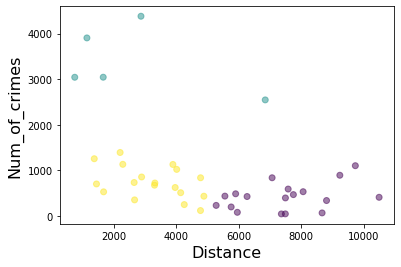

In [24]:
plt.scatter(X[:, 1], X[:, 0], c=labels.astype(np.float), alpha=0.5)
plt.ylabel('Num_of_crimes', fontsize=16)
plt.xlabel('Distance', fontsize=16)

plt.savefig('Distribution_of_Neighborhoods.png')

plt.show()

Therefore we will keep neighborhoods in cluster 2 (yellow).

In [25]:
df_neighborhood = df_plot.drop(df_plot.index[df_plot['Labels'] != 2])
df_neighborhood = df_neighborhood.drop(['Labels'],axis=1)
df_neighborhood = df_neighborhood.reset_index(drop=True)
df_neighborhood

,Neighborhood,Num_of_crimes,Distance,Latitude,Longitude
0,Treasure Island,115,4775.187494,37.815691,-122.367322
1,Presidio Heights,246,4255.033980,37.784668,-122.451945
2,Japantown,349,2662.474054,37.784767,-122.433846
3,Noe Valley,430,4883.753181,37.747638,-122.435390
4,Lone Mountain/USF,507,4140.196872,37.779203,-122.450308
5,Mission Bay,526,1669.362921,37.777850,-122.386186
6,Haight Ashbury,621,3963.476056,37.767229,-122.443559
7,Potrero Hill,672,3301.999091,37.758275,-122.384201
8,Chinatown,699,1440.908662,37.796295,-122.407744
9,Russian Hill,720,3313.224595,37.808877,-122.423921


Ok, now we have our candidate neighborhoods ready.

#### Create a Choropleth map

In order to create a Choropleth map, we need a GeoJSON file that defines the areas/boundaries of San Francisco. We can find the GeoJSON file from [sfgov](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h).

In [26]:
sf_geo = r'SF_Analysis_Neighborhoods.geojson' # geojson file

# San Francisco latitude and longitude values
latitude = 37.77
longitude = -122.42

# create a numpy array of length 5 and has linear spacing from the minium number of crimes  to the maximum number of crimes
threshold_scale = np.linspace(df_merge['Num_of_crimes'].min(),
                              df_merge['Num_of_crimes'].max(),
                              5, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum  number of crimes

# create map and display it
sf_ch_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# generate choropleth map
sf_ch_map.choropleth(
    geo_data = sf_geo,
    data = df_group,
    columns = ['Neighborhood', 'Num_of_crimes'],
    key_on = 'feature.properties.nhood',
    threshold_scale = threshold_scale,
    fill_color = 'Greys', 
    fill_opacity = 0.9, 
    line_opacity = 0.9,
    legend_name = 'San Francisco Neighborhoods: Num of crimes'
)


# instantiate a feature group for the tech companies in the dataframe
companies = folium.map.FeatureGroup()

# loop through the 586 tech companies and add each to the companies feature group
for lat, lng, in zip(df_tc.Latitude, df_tc.Longitude):
    companies.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=2, 
            color='deepskyblue',
        )
    )

# add companies to map
sf_ch_map.add_child(companies)

# add company centroid marker
folium.Marker(tc_center_latlon, popup='SF Tech Company Centroid').add_to(sf_ch_map)
# add average distance circle for each cluster
folium.Circle([tc_center_latlon[0], tc_center_latlon[1]], radius=df_pg.loc[0][1], color='dodgerblue', fill=False).add_to(sf_ch_map)
folium.Circle([tc_center_latlon[0], tc_center_latlon[1]], radius=df_pg.loc[1][1], color='dodgerblue', fill=False).add_to(sf_ch_map)
folium.Circle([tc_center_latlon[0], tc_center_latlon[1]], radius=df_pg.loc[2][1], color='dodgerblue', fill=False).add_to(sf_ch_map)

sf_ch_map

If the map above doesn't show, please see image attached in the markdown area:
![](https://miro.medium.com/max/1400/1*mK7OqYMlx3wlm3jwwo804w.png)

Lighter areas indicate high levels of safety. Maker and circle show where the company gathers.

In [27]:
# save maps as an image
import os
import time
from selenium import webdriver

# save this map as an image
delay=3
fn='sf_choropleth_map_with_marker_and_circle.html'
tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
sf_ch_map.save(fn)

browser = webdriver.Chrome('/Applications/chromedriver')
browser.fullscreen_window()
browser.get(tmpurl)
#Give the map tiles some time to load
time.sleep(delay)
browser.save_screenshot('sf_choropleth_map_with_marker_and_circle.html.png')
browser.quit()

#### Create a map of San Francisco with candidate neighborhoods superimposed on top.

In [28]:
# create map and display all candidate neighborhoods as points
sf_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# loop through the 18 neighborhoods and add each to the map
for lat, lng, nei in zip(df_neighborhood.Latitude, df_neighborhood.Longitude, df_neighborhood.Neighborhood):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color='dimgrey',
        fill=True,
        popup=nei,
        fill_color='lightsteelblue',
        fill_opacity=0.6
    ).add_to(sf_map)

# show map
sf_map

If the map above doesn't show, please see image attached in the markdown area:
![](https://miro.medium.com/max/1400/1*mQoRUOZ4u1nnohQ_0yn4dQ.png)

In [30]:
# save this map as an image
delay=3
fn='sf_candidate_neighborhoods_map.html'
tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
sf_map.save(fn)

browser = webdriver.Chrome('/Applications/chromedriver')
browser.fullscreen_window()
browser.get(tmpurl)
#Give the map tiles some time to load
time.sleep(delay)
browser.save_screenshot('sf_candidate_neighborhoods_map.html.png')
browser.quit()

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [31]:
CLIENT_ID = '*****************************************' # your Foursquare ID
CLIENT_SECRET = '*************************************' # your Foursquare Secret
VERSION = '*******' # Foursquare API version

#### Create a function to explore all the candidate neighborhoods in San Francisco

In [32]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [34]:
# Get the top 100 venues within a radius of 500 meters.
LIMIT = 100
radius = 500

# Run the above function on each neighborhood and create a new dataframe called sf_venues.
sf_venues = getNearbyVenues(names=df_neighborhood['Neighborhood'],
                                   latitudes=df_neighborhood['Latitude'],
                                   longitudes=df_neighborhood['Longitude']
                                  )

Treasure Island
Presidio Heights
Japantown
Noe Valley
Lone Mountain/USF
Mission Bay
Haight Ashbury
Potrero Hill
Chinatown
Russian Hill
Pacific Heights
Bernal Heights
North Beach
Marina
Castro/Upper Market
Hayes Valley
Nob Hill
Western Addition


In [35]:
# Check the size of the resulting dataframe
print(sf_venues.shape)
sf_venues.head()

(971, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Treasure Island,37.815691,-122.367322,Woods Island Club,37.818278,-122.367314,Brewery
1,Treasure Island,37.815691,-122.367322,Treasure Island Museum,37.816996,-122.371254,History Museum
2,Treasure Island,37.815691,-122.367322,Treasure Island Yacht Club,37.816616,-122.370483,Harbor / Marina
3,Treasure Island,37.815691,-122.367322,Kite the Bay,37.815853,-122.370839,Harbor / Marina
4,Treasure Island,37.815691,-122.367322,Clipper Cove Beach,37.813293,-122.370894,Beach


In [36]:
# Check how many venues were returned for each neighborhood
print(sf_venues.groupby('Neighborhood').size().reset_index(name='Num_of_venues'))

# Check how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(sf_venues['Venue Category'].unique())))

           Neighborhood  Num_of_venues
0        Bernal Heights             43
1   Castro/Upper Market             84
2             Chinatown             89
3        Haight Ashbury             31
4          Hayes Valley            100
5             Japantown             93
6     Lone Mountain/USF             33
7                Marina             11
8           Mission Bay             43
9              Nob Hill            100
10           Noe Valley             45
11          North Beach             51
12      Pacific Heights             39
13         Potrero Hill             43
14     Presidio Heights             36
15         Russian Hill             64
16      Treasure Island             11
17     Western Addition             55
There are 227 uniques categories.


#### Analyze Each Neighborhood

In [37]:
# one hot encoding
sf_onehot = pd.get_dummies(sf_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sf_onehot['Neighborhood'] = sf_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sf_onehot.columns[-1]] + list(sf_onehot.columns[:-1])
sf_onehot = sf_onehot[fixed_columns]

print(sf_onehot.shape)
sf_onehot.head()

(971, 227)


,Zoo Exhibit,Accessories Store,Adult Boutique,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Boat or Ferry,Bookstore,Boutique,Bowling Green,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Hill,Historic Site,History Museum,Home Service,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mini Golf,Miscellaneous Shop,Monument / Landmark,Museum,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pedestrian Plaza,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Physical Therapist,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Pool Hall,Pop-Up Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Resort,Restaurant,Roller Rink,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Tunnel,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Wings Joint,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Treasure Island,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Treasure Island,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [38]:
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
sf_grouped = sf_onehot.groupby('Neighborhood').mean().reset_index()

#Comfirm the new size
print(sf_grouped.shape)
sf_grouped.head()

(18, 227)


,Neighborhood,Zoo Exhibit,Accessories Store,Adult Boutique,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Boat or Ferry,Bookstore,Boutique,Bowling Green,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,Hill,Historic Site,History Museum,Home Service,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mini Golf,Miscellaneous Shop,Monument / Landmark,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pedestrian Plaza,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Physical Therapist,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Pool Hall,Pop-Up Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Resort,Restaurant,Roller Rink,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Tunnel,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Wings Joint,Yoga Studio
0,Bernal Heights,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.023256,0.0,0.0,0.0,0.00,0.069767,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.000000,0.000000,0.0,0.000000,0.023256,0.000000,0.023256,0.023256,0.0,0.023256,0.0,0.023256,0.023256,0.023256,0.000000,0.023256,0.0,0.00000,0.00,0.000000,0.00,0.0,0.000000,0.023256,0.069767,0.0,0.00,0.00,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.023256,0.00,0.093023,0.0,0.00,0.00,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.023256,0.000000,0.00,0.023256,0.046512,0.023256,0.023256,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.023256,0.000000,0.046512,0.000000,0.000000,0.000000,0.000000,0.0,0.

In [39]:
# print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in sf_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sf_grouped[sf_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bernal Heights----
          venue  freq
0    Food Truck  0.09
1    Playground  0.07
2   Coffee Shop  0.07
3        Bakery  0.07
4  Gourmet Shop  0.05


----Castro/Upper Market----
             venue  freq
0          Gay Bar  0.08
1      Coffee Shop  0.06
2  Thai Restaurant  0.05
3             Park  0.05
4   Scenic Lookout  0.02


----Chinatown----
                venue  freq
0         Coffee Shop  0.10
1  Chinese Restaurant  0.06
2         Men's Store  0.04
3        Cocktail Bar  0.04
4                Café  0.04


----Haight Ashbury----
                    venue  freq
0                Boutique  0.06
1          Breakfast Spot  0.06
2                    Park  0.06
3          Scenic Lookout  0.06
4  Thrift / Vintage Store  0.06


----Hayes Valley----
               venue  freq
0           Wine Bar  0.05
1       Cocktail Bar  0.04
2               Café  0.04
3   Sushi Restaurant  0.04
4  French Restaurant  0.04


----Japantown----
           venue  freq
0       Tea Room  0.04
1      Gi

In [40]:
# Define a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sf_grouped['Neighborhood']

for ind in np.arange(sf_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sf_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bernal Heights,Food Truck,Playground,Bakery,Coffee Shop,Park,Italian Restaurant,Gourmet Shop,Gay Bar,Pet Store,Peruvian Restaurant
1,Castro/Upper Market,Gay Bar,Coffee Shop,Thai Restaurant,Park,Yoga Studio,Clothing Store,Cosmetics Shop,Deli / Bodega,Hill,Playground
2,Chinatown,Coffee Shop,Chinese Restaurant,Café,Pizza Place,Italian Restaurant,Cocktail Bar,Men's Store,New American Restaurant,Dim Sum Restaurant,Bakery
3,Haight Ashbury,Park,Boutique,Breakfast Spot,Thrift / Vintage Store,Scenic Lookout,Coffee Shop,Smoke Shop,Skate Park,Shoe Store,Clothing Store
4,Hayes Valley,Wine Bar,French Restaurant,Sushi Restaurant,Café,Cocktail Bar,Record Shop,Dessert Shop,Clothing Store,Park,Optical Shop


In [41]:
df_final = pd.merge(left=neighborhoods_venues_sorted, right=df_neighborhood, left_on='Neighborhood', right_on='Neighborhood')
df_final

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Num_of_crimes,Distance,Latitude,Longitude
0,Bernal Heights,Food Truck,Playground,Bakery,Coffee Shop,Park,Italian Restaurant,Gourmet Shop,Gay Bar,Pet Store,Peruvian Restaurant,835,4777.619477,37.741462,-122.414034
1,Castro/Upper Market,Gay Bar,Coffee Shop,Thai Restaurant,Park,Yoga Studio,Clothing Store,Cosmetics Shop,Deli / Bodega,Hill,Playground,1127,3890.423112,37.761351,-122.437652
2,Chinatown,Coffee Shop,Chinese Restaurant,Café,Pizza Place,Italian Restaurant,Cocktail Bar,Men's Store,New American Restaurant,Dim Sum Restaurant,Bakery,699,1440.908662,37.796295,-122.407744
3,Haight Ashbury,Park,Boutique,Breakfast Spot,Thrift / Vintage Store,Scenic Lookout,Coffee Shop,Smoke Shop,Skate Park,Shoe Store,Clothing Store,621,3963.476056,37.767229,-122.443559
4,Hayes Valley,Wine Bar,French Restaurant,Sushi Restaurant,Café,Cocktail Bar,Record Shop,Dessert Shop,Clothing Store,Park,Optical Shop,1130,2284.717745,37.774467,-122.426813
5,Japantown,Grocery Store,Gift Shop,Bakery,Tea Room,Boutique,Shopping Mall,Spa,Cosmetics Shop,Café,Japanese Restaurant,349,2662.474054,37.784767,-122.433846
6,Lone Mountain/USF,Coffee Shop,Salon / Barbershop,Wine Bar,Café,Pub,Sushi Restaurant,Supplement Shop,Diner,Liquor Store,Big Box Store,507,4140.196872,37.779203,-122.450308
7,Marina,Harbor / Marina,Coffee Shop,Bank,Lighthouse,Gym,Gym / Fitness Center,Monument / Landmark,Historic Site,Park,Event Space,1019,4012.133119,37.806849,-122.438672
8,Mission Bay,Baseball Stadium,Outdoor Sculpture,Coffee Shop,Park,Harbor / Marina,Sandwich Place,Garden,Café,Pop-Up Shop,Nightclub,526,1669.362921,37.777850,-122.386186
9,Nob Hill,Hotel,Coffee Shop,Italian Restaurant,Grocery Store,Café,Bar,American Restaurant,Spa,French Restaurant,Yoga Studio,1253,1369.714995,37.792162,-122.414994


Looking good. So now we have all the neighborhoods in San Francisco, and we know which one have less number of crimes, which neighborhoods exactly are in vicinity of the centroid of all tech companies. And we also know the top 10 venues for each neighborhood.

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on optimal locations.

## Analysis <a name="analysis"></a>

K-means is especially useful if you need to quickly discover insights from unlabeled data. To determine the optimal number of clusters, we have to select the value of k at the “elbow”:

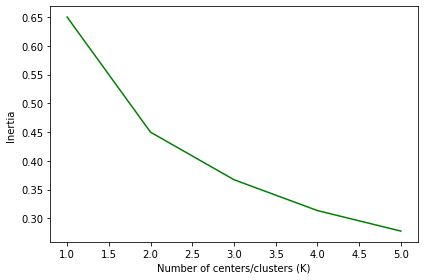

In [42]:
Ks = 6 # number of ks we will test
inertias = np.zeros((Ks-1))

sf_grouped_clustering = sf_grouped.drop('Neighborhood', 1)

for n in range(1,Ks):
    
    # run k-means clustering
    kmeans = KMeans(n_clusters=n, random_state=0).fit(sf_grouped_clustering)
    inertias[n-1] = kmeans.inertia_

# display the inertia    
inertias

# Plot the inertia with the different k to find the better balance
plt.plot(range(1,Ks),inertias,'g')
plt.ylabel('Inertia ')
plt.xlabel('Number of centers/clusters (K)')
plt.tight_layout()

plt.savefig('find_best_k.png')

plt.show()

Run k-means to cluster the neighborhood into 2 clusters.

In [43]:
# Set number of clusters
kclusters = 2

sf_grouped_clustering = sf_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sf_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [44]:
# add clustering labels
df_final.insert(0, 'Cluster Labels', kmeans.labels_)
df_final.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Num_of_crimes,Distance,Latitude,Longitude
0,0,Bernal Heights,Food Truck,Playground,Bakery,Coffee Shop,Park,Italian Restaurant,Gourmet Shop,Gay Bar,Pet Store,Peruvian Restaurant,835,4777.619477,37.741462,-122.414034
1,0,Castro/Upper Market,Gay Bar,Coffee Shop,Thai Restaurant,Park,Yoga Studio,Clothing Store,Cosmetics Shop,Deli / Bodega,Hill,Playground,1127,3890.423112,37.761351,-122.437652
2,0,Chinatown,Coffee Shop,Chinese Restaurant,Café,Pizza Place,Italian Restaurant,Cocktail Bar,Men's Store,New American Restaurant,Dim Sum Restaurant,Bakery,699,1440.908662,37.796295,-122.407744
3,0,Haight Ashbury,Park,Boutique,Breakfast Spot,Thrift / Vintage Store,Scenic Lookout,Coffee Shop,Smoke Shop,Skate Park,Shoe Store,Clothing Store,621,3963.476056,37.767229,-122.443559
4,0,Hayes Valley,Wine Bar,French Restaurant,Sushi Restaurant,Café,Cocktail Bar,Record Shop,Dessert Shop,Clothing Store,Park,Optical Shop,1130,2284.717745,37.774467,-122.426813


In [45]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.prism(np.linspace(0, 1, len(ys)))
prism = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_final['Latitude'], df_final['Longitude'], df_final['Neighborhood'], df_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=prism[cluster-1],
        fill=True,
        fill_color=prism[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

If the map above doesn't show, please see image attached in the markdown area:
![](https://miro.medium.com/max/1400/1*9UcJRILWl5o3wEX7yXrF_Q.png)

In [46]:
# save this map as an image
delay=3
fn='sf_candidate_neighborhoods_clusters_map.html'
tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
map_clusters.save(fn)

browser = webdriver.Chrome('/Applications/chromedriver')
browser.fullscreen_window()
browser.get(tmpurl)
#Give the map tiles some time to load
time.sleep(delay)
browser.save_screenshot('sf_candidate_neighborhoods_clusters_map.html.png')
browser.quit()

#### Examine clusters

In [47]:
# Cluster 1 (green)
df_final.loc[df_final['Cluster Labels'] == 0, df_final.columns[list(range(1,12))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bernal Heights,Food Truck,Playground,Bakery,Coffee Shop,Park,Italian Restaurant,Gourmet Shop,Gay Bar,Pet Store,Peruvian Restaurant
1,Castro/Upper Market,Gay Bar,Coffee Shop,Thai Restaurant,Park,Yoga Studio,Clothing Store,Cosmetics Shop,Deli / Bodega,Hill,Playground
2,Chinatown,Coffee Shop,Chinese Restaurant,Café,Pizza Place,Italian Restaurant,Cocktail Bar,Men's Store,New American Restaurant,Dim Sum Restaurant,Bakery
3,Haight Ashbury,Park,Boutique,Breakfast Spot,Thrift / Vintage Store,Scenic Lookout,Coffee Shop,Smoke Shop,Skate Park,Shoe Store,Clothing Store
4,Hayes Valley,Wine Bar,French Restaurant,Sushi Restaurant,Café,Cocktail Bar,Record Shop,Dessert Shop,Clothing Store,Park,Optical Shop
5,Japantown,Grocery Store,Gift Shop,Bakery,Tea Room,Boutique,Shopping Mall,Spa,Cosmetics Shop,Café,Japanese Restaurant
6,Lone Mountain/USF,Coffee Shop,Salon / Barbershop,Wine Bar,Café,Pub,Sushi Restaurant,Supplement Shop,Diner,Liquor Store,Big Box Store
8,Mission Bay,Baseball Stadium,Outdoor Sculpture,Coffee Shop,Park,Harbor / Marina,Sandwich Place,Garden,Café,Pop-Up Shop,Nightclub
9,Nob Hill,Hotel,Coffee Shop,Italian Restaurant,Grocery Store,Café,Bar,American Restaurant,Spa,French Restaurant,Yoga Studio
10,Noe Valley,Gift Shop,Italian Restaurant,American Restaurant,Trail,Bakery,Yoga Studio,Bookstore,Martial Arts Dojo,Burger Joint,Shipping Store


In [48]:
# Cluster 2 (red)
df_final.loc[df_final['Cluster Labels'] == 1, df_final.columns[list(range(1,12))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Marina,Harbor / Marina,Coffee Shop,Bank,Lighthouse,Gym,Gym / Fitness Center,Monument / Landmark,Historic Site,Park,Event Space
16,Treasure Island,Harbor / Marina,Music Venue,History Museum,Bus Station,Brewery,Fried Chicken Joint,Beach,Event Space,Eastern European Restaurant,Electronics Store


Let’s use bar chart to visualize number of 1st most common venues in each cluster:

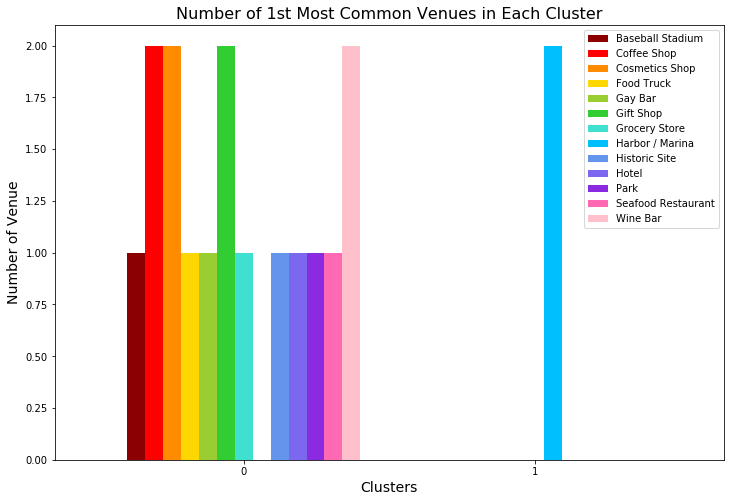

In [54]:
count_venue = df_final.loc[:, df_final.columns[list(range(0,12))]]
count_venue = count_venue.drop(['Neighborhood'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

# we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)


#creating a bar chart of "Number of Venues in Each Cluster"
mycolors = ['darkred','red','darkorange','gold','yellowgreen','limegreen','turquoise','deepskyblue','cornflowerblue','mediumslateblue','blueviolet','hotpink','pink']

cv_cluster.plot(kind='bar',figsize=(12,8),width=0.8,color=mycolors,align='center')

plt.title("Number of 1st Most Common Venues in Each Cluster",fontsize= 16)

plt.xticks(rotation=0)

plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Number of Venue', fontsize=14)

plt.legend(labels=cv_cluster.columns,fontsize= 10)

plt.savefig('num_of_1st_most_common_vanues_in_each_cluster.png')

After examining each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories we can create a profile for each group, considering the common characteristics of each cluster:

**Cluster 0**: Multiple Social Venues

**Cluster 1**: Harbor / Marina Venues

<br>

## Results and Discussion <a name="results"></a>

Our analysis shows that there are 41 neighborhoods in San Francisco, and we get 18 of them both have less number of crimes, and not far apart to the tech companies. Then by clustering those 18 neighborhoods into two clusters, we can finally make recommendations to stakeholders who relocate to San Francisco and want to find an optimal place to live.

My Project has many place to be improved, for example, we can use population data to calculate the crime rate instead of number of crimes. We can also use commute time instead of distance. Apartment data can be explored further.

Recommended neighborhoods should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only safety and nearby competition but also other factors taken into account and all other relevant conditions met.

<br>

## Conclusion <a name="conclusion"></a>

By modeling the distribution of neighborhoods based on their number of crimes and distance to the tech companies we have first identified general neighborhoods that justify further analysis. Then explore those neighborhoods and get the top 10 venues for each neighborhood. Clustering of those locations was then performed in order to create major zones of interest.

Because there are only a few neighborhoods in San Francisco, we can’t really get insightful clusters.

Final decision on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.
